In [1]:
import json
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
vocab_size = 10000
embedding_dim = 16
max_length = 200
trunc_type='post'
padding_type='post' 
oov_tok = "<OOV>"
training_size = 700000
total_size = 1000000

In [3]:
# with open("./sarcasm.json", 'r') as f:
#     datastore = json.load(f)

# sentences = []
# labels = []

# for item in datastore:
#     sentences.append(item['headline'])
#     labels.append(item['is_sarcastic'])
#print(list(zip(sentences,labels)))

import pandas as pd

data = pd.read_csv('train-balanced-sarcasm.csv', usecols=['comment','label','score'], index_col=False)
data = data.reindex(columns=['comment','label','score'])
data.dropna(inplace=True)
data = data.sort_values(by='score', ascending=False)
sentences = data['comment']
labels = data['label']
data.head()

,comment,label,score
143497,That's exactly what a country who made up a ho...,1,9070
157472,but it still snows,1,7563
110228,"lol, you can't make this stuff up.",0,5818
53985,He didn't drink the compliance,0,5629
689739,"In the Half Life series, the reason Gordon Fre...",0,5163


In [8]:
training_sentences = sentences.tolist()[:training_size]
testing_sentences = sentences.tolist()[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

In [155]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [180]:
import pickle
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=4)

In [156]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [157]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 16)           160000    
_________________________________________________________________
global_average_pooling1d_1 ( (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 24)                408       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 25        
Total params: 160,433
Trainable params: 160,433
Non-trainable params: 0
_________________________________________________________________


In [158]:
history = model.fit(training_padded, training_labels, epochs=15, validation_data=(testing_padded, testing_labels), verbose=2)

Epoch 1/15
21875/21875 - 88s - loss: 0.6010 - accuracy: 0.6723 - val_loss: 0.5877 - val_accuracy: 0.6828
Epoch 2/15
21875/21875 - 93s - loss: 0.5706 - accuracy: 0.7038 - val_loss: 0.6003 - val_accuracy: 0.6793
Epoch 3/15
21875/21875 - 88s - loss: 0.5625 - accuracy: 0.7106 - val_loss: 0.5778 - val_accuracy: 0.6958
Epoch 4/15
21875/21875 - 84s - loss: 0.5568 - accuracy: 0.7141 - val_loss: 0.5740 - val_accuracy: 0.6974
Epoch 5/15
21875/21875 - 88s - loss: 0.5526 - accuracy: 0.7172 - val_loss: 0.5819 - val_accuracy: 0.6916
Epoch 6/15
21875/21875 - 83s - loss: 0.5492 - accuracy: 0.7193 - val_loss: 0.5743 - val_accuracy: 0.6971
Epoch 7/15
21875/21875 - 84s - loss: 0.5467 - accuracy: 0.7214 - val_loss: 0.5812 - val_accuracy: 0.6917
Epoch 8/15
21875/21875 - 84s - loss: 0.5444 - accuracy: 0.7228 - val_loss: 0.5751 - val_accuracy: 0.6974
Epoch 9/15
21875/21875 - 91s - loss: 0.5421 - accuracy: 0.7248 - val_loss: 0.5740 - val_accuracy: 0.6990
Epoch 10/15
21875/21875 - 85s - loss: 0.5400 - accuracy

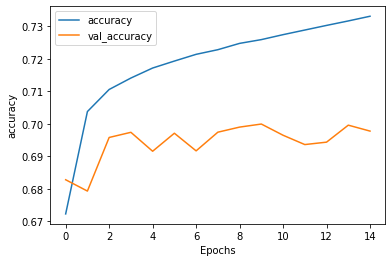

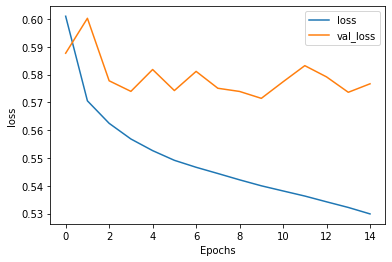

In [159]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [175]:
model.save('model')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: model/assets


In [176]:
tf.keras.models.load_model('model')

In [177]:
sentence = input("sentence: ")
sequences = tokenizer.texts_to_sequences([sentence])
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print('Sarcasm' if model.predict(padded)[0][0]>0.5 else 'Not Sarcasm')

sentence: omg hax
Sarcasm
